In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[ns]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [16]:
df.trip_type.value_counts()

1.0    39233
2.0     1238
Name: trip_type, dtype: int64

In [17]:
df['duration'] = df.lpep_dropoff_datetime  - df.lpep_pickup_datetime   

In [18]:
df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)

# td = df.duration.iloc[0]
# td.total_seconds()/60

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

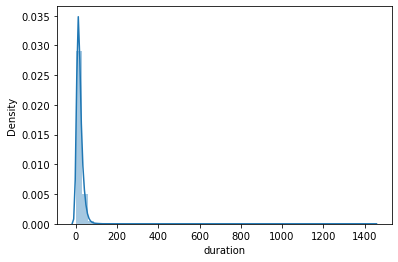

In [19]:
sns.distplot(df.duration)

In [20]:
df.duration.describe(percentiles=[0.95, 0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [21]:
((df.duration>=1) & (df.duration<=60)).mean()

0.9658903787344154

In [22]:
df = df[((df.duration>=1) & (df.duration<=60))]

In [23]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')

In [24]:
categorical =['PULocationID','DOLocationID' ]
numerical =['trip_distance']

In [25]:
df[categorical] = df[categorical].astype(str)

In [7]:
from sklearn.feature_extraction import DictVectorizer

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
from sklearn.linear_model import Lasso

In [10]:
from sklearn.linear_model import Ridge

In [11]:
from sklearn.metrics import mean_squared_error

In [26]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [27]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [20]:
X_train[:10]

<10x507 sparse matrix of type '<class 'numpy.float64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [21]:
target ='duration'
y_train = df[target].values

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred = lr.predict(X_train)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


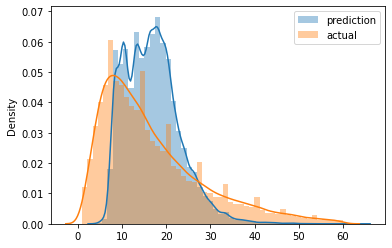

In [24]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [36]:
mean_squared_error(y_train, y_pred, squared=False)

9.775464278878395

In [28]:
#### Modularizing the code 

def read_dataframe(filename):

    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime  - df.lpep_pickup_datetime   
    df['duration'] = df['duration'].apply(lambda td: td.total_seconds()/60)

    df = df[((df.duration>=1) & (df.duration<=60))]

    categorical =['PULocationID','DOLocationID' ]
    #numerical =['trip_distance']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [29]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [30]:
len(df_train), len(df_val)

(73908, 61921)

In [31]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [32]:
categorical =  ['PU_DO'] #['PULocationID','DOLocationID' ]
numerical =['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical ].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [33]:
target ='duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [34]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.480879703714338

In [35]:
lr = Lasso(0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.23346989760693

In [36]:
lr = Ridge(0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479495067043056

In [37]:
import pickle

In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump